## Importing the dependencies

In [ ]:
!pip install fuzzywuzzy

## Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score
import gensim
from gensim import corpora
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import json
from google.colab import files
from torch.optim import AdamW
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', -1)
import ast
import io
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import pipeline
from fuzzywuzzy import process
import gensim.downloader as api
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertModel, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-2-2dd819556868>:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# Upload file from your local machine
uploaded = files.upload()

Saving Finance_ABSA -BERT.csv to Finance_ABSA -BERT.csv


In [ ]:
# Assuming the file name is 'Finance_ABSA.csv'
data = pd.read_csv(io.BytesIO(uploaded['Finance_ABSA -BERT.csv']))

# Displaying the first few rows of the dataframe
data.head()

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Prakash Diwan","{""Market"": ""neutral""}",8


In [ ]:
data.shape

(10753, 4)

In [ ]:
data.isnull().sum()

S No.        0
Title        0
Decisions    0
Words        0
dtype: int64

In [ ]:
data[data.duplicated()]

,S No.,Title,Decisions,Words


In [ ]:
# Function to parse the 'Decisions' column and return it as a dictionary
def parse_decisions(decisions):
    try:
        return json.loads(decisions)
    except json.JSONDecodeError:
        return {}

# Apply basic text preprocessing: lowercasing and stripping leading/trailing whitespaces
data['Title'] = data['Title'].str.lower().str.strip()

# Apply the parsing function to the 'Decisions' column
data['Parsed_Decisions'] = data['Decisions'].apply(parse_decisions)

# Expand the dataframe
expanded_data = []
for _, row in data.iterrows():
    for aspect, sentiment in row['Parsed_Decisions'].items():
        expanded_data.append([row['Title'], aspect, sentiment, row['Words']])

dataset = pd.DataFrame(expanded_data, columns=['Title', 'Aspect', 'Sentiment','words'])

In [ ]:
dataset.drop(columns=['words'], inplace=True)

In [ ]:
dataset.head()

,Title,Aspect,Sentiment
0,spicejet to issue 6.4 crore warrants to promoters,SpiceJet,neutral
1,mmtc q2 net loss at rs 10.4 crore,MMTC,neutral
2,"mid-cap funds can deliver more, stay put: experts",Mid-cap funds,positive
3,mid caps now turn into market darlings,Mid caps,positive
4,"market seeing patience, if not conviction: prakash diwan",Market,neutral


In [ ]:
dataset.isnull().sum()

Title        0
Aspect       0
Sentiment    0
dtype: int64

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14409 entries, 0 to 14408
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      14409 non-null  object
 1   Aspect     14409 non-null  object
 2   Sentiment  14409 non-null  object
dtypes: object(3)
memory usage: 337.8+ KB


In [ ]:
dataset[dataset.duplicated()]

,Title,Aspect,Sentiment
333,manappuram finance launches another public issue,Manappuram Finance,neutral
364,stock-specific action likely on it counters: nitin raheja,IT,neutral
382,mark mobius expects 15-20% returns from indian markets,Indian markets,neutral
729,noel n tata takes over as chairman of trent,Trent,neutral
745,p padmanabhan takes charge as md numaligarh refinery ltd,Numaligarh Refinery Ltd,neutral
...,...,...,...
13582,"gold holds below 2-week high on robust dollar, us economy",dollar,positive
13701,"gloomy french data hits european stocks, iraq keeps oil high",oil,positive
13702,"gloomy french data hits european stocks, iraq keeps oil high",European stocks,negative
14247,"forex, stocks rebound as ukraine concerns less acute",Forex,positive


Text(0, 0.5, 'Count')

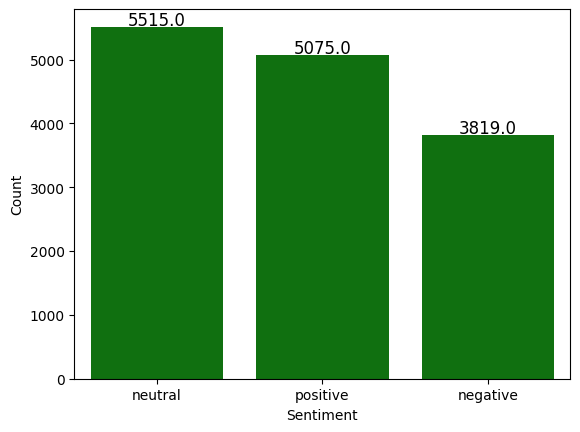

In [ ]:
# Create a count plot
ax = sns.countplot(data=dataset, x='Sentiment', color='green')

# Annotate the bars with their counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Set labels for the axes
plt.xlabel('Sentiment')
plt.ylabel('Count')


In [ ]:
dataset['Aspect'].value_counts()

Nifty                      421
Sebi                       320
Sensex                     281
Infosys                    131
Gold                       123
                          ... 
Electrosteel Castings      1  
Foreign brokerages         1  
agriculture commodities    1  
global commodities         1  
Chambal                    1  
Name: Aspect, Length: 4275, dtype: int64

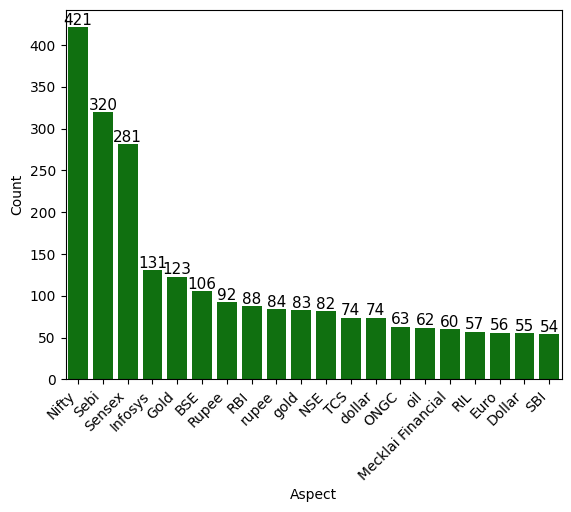

In [ ]:
# Get the counts of each unique value in 'Aspect' and pick the top 20
top_aspects = dataset['Aspect'].value_counts().nlargest(20).index

# Filter the dataset to only include the top 20 aspects
top_dataset = dataset[dataset['Aspect'].isin(top_aspects)]

# Create a count plot for the top 20 aspects
ax = sns.countplot(data=top_dataset, x='Aspect', order=top_aspects, color='green')

# Annotate the bars with their counts
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black',
                xytext=(0, 5), textcoords='offset points')

# Set labels for the axes
plt.xlabel('Aspect')
plt.ylabel('Count')

# Rotate the x labels for better readability if they overlap
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
len(dataset['Title'])

14409

In [ ]:
# Calculate the length of each review
lengths = dataset['Title'].str.len()

# Find the max and min lengths
max_length = lengths.max()
min_length = lengths.min()

In [ ]:
max_length

135

In [ ]:
max_length_review = dataset.loc[dataset['Title'].str.len() == max_length, 'Title']
max_length_review

5494    fed's stand on interest rates could be biggest global macro turbulence causer in near term: arvind sanger, geosphere capital management
Name: Title, dtype: object

In [ ]:
min_length

18

In [ ]:
min_length_review = dataset.loc[dataset['Title'].str.len() == min_length, 'Title']
min_length_review

227      ntpc files for fpo
11227    gold's allure dims
Name: Title, dtype: object

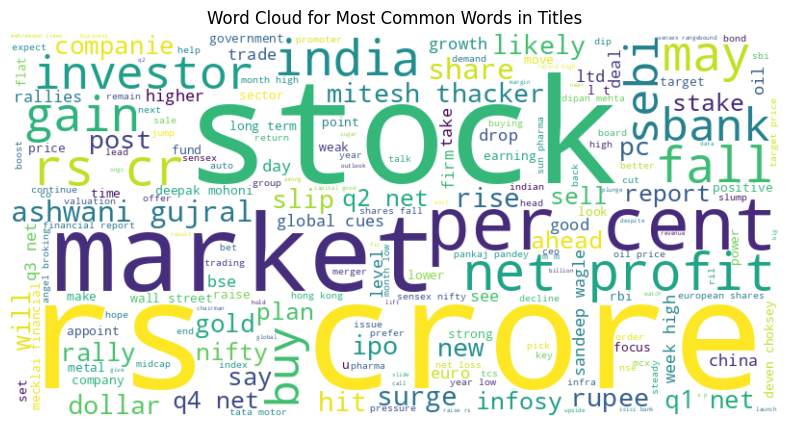

In [ ]:
# Combine all titles into a single string
all_titles = ' '.join(dataset['Title'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Most Common Words in Titles')
plt.show()

In [ ]:
# dataset.to_csv('Finance_data_ABSA.csv', index=False)

In [ ]:
import os
current_directory = os.getcwd()
current_directory

'/content'

In [ ]:
# Custom model for multi-task learning
class BertForMultiTask(nn.Module):
    def __init__(self, num_aspect_labels, num_sentiment_labels):
        super(BertForMultiTask, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.aspect_classifier = nn.Linear(self.bert.config.hidden_size, num_aspect_labels)
        self.sentiment_classifier = nn.Linear(self.bert.config.hidden_size, num_sentiment_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        aspect_logits = self.aspect_classifier(pooled_output)
        sentiment_logits = self.sentiment_classifier(pooled_output)
        return aspect_logits, sentiment_logits


# Initialize tokenizers and label encoders
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
label_encoder_aspect = LabelEncoder()
label_encoder_sentiment = LabelEncoder()

# Encode labels
label_encoder_aspect.fit(dataset['Aspect'])
label_encoder_sentiment.fit(dataset['Sentiment'])

input_ids = []
attention_masks = []
aspect_labels = []
sentiment_labels = []

for _, row in dataset.iterrows():
    text = row['Title']
    aspect = row['Aspect']
    sentiment = row['Sentiment']

    # Tokenize the text
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Append the tokenized information
    input_ids.append(encoded_dict['input_ids'][0])
    attention_masks.append(encoded_dict['attention_mask'][0])

    # Append corresponding labels
    aspect_labels.append(label_encoder_aspect.transform([aspect])[0])
    sentiment_labels.append(label_encoder_sentiment.transform([sentiment])[0])

# Convert lists into tensors
input_ids = torch.stack(input_ids, dim=0)
attention_masks = torch.stack(attention_masks, dim=0)
aspect_labels = torch.tensor(aspect_labels)
sentiment_labels = torch.tensor(sentiment_labels)

# Split data
train_inputs, validation_inputs, train_aspect_labels, validation_aspect_labels, train_sentiment_labels, validation_sentiment_labels = train_test_split(input_ids, aspect_labels, sentiment_labels, random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

# DataLoader
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_aspect_labels, train_sentiment_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_aspect_labels, validation_sentiment_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Initialize model
num_aspect_labels = len(label_encoder_aspect.classes_)
num_sentiment_labels = len(label_encoder_sentiment.classes_)
model = BertForMultiTask(num_aspect_labels, num_sentiment_labels)
model.cuda()

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Training loop
epochs = 4
for epoch_i in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_aspect_labels = batch[2].cuda()
        b_sentiment_labels = batch[3].cuda()

        model.zero_grad()

        aspect_logits, sentiment_logits = model(b_input_ids, attention_mask=b_input_mask)

        loss_fct = nn.CrossEntropyLoss()
        aspect_loss = loss_fct(aspect_logits, b_aspect_labels)
        sentiment_loss = loss_fct(sentiment_logits, b_sentiment_labels)
        total_loss = aspect_loss + sentiment_loss

        total_train_loss += total_loss.item()
        total_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 4 ========
Average training loss: 8.56
======== Epoch 2 / 4 ========
Average training loss: 7.54
======== Epoch 3 / 4 ========
Average training loss: 7.10
======== Epoch 4 / 4 ========
Average training loss: 6.78


In [ ]:
# Save model
# model.save_pretrained('path_to_save_model')

In [ ]:
# Evaluation Function
def evaluate(model, dataloader):
    model.eval()
    aspect_preds, sentiment_preds = [], []
    true_aspect_labels, true_sentiment_labels = [], []

    for batch in dataloader:
        batch = tuple(t.cuda() for t in batch)
        b_input_ids, b_input_mask, b_aspect_labels, b_sentiment_labels = batch

        with torch.no_grad():
            aspect_logits, sentiment_logits = model(b_input_ids, attention_mask=b_input_mask)

        aspect_logits = aspect_logits.detach().cpu().numpy()
        sentiment_logits = sentiment_logits.detach().cpu().numpy()
        label_ids_aspect = b_aspect_labels.to('cpu').numpy()
        label_ids_sentiment = b_sentiment_labels.to('cpu').numpy()

        aspect_preds.append(aspect_logits)
        sentiment_preds.append(sentiment_logits)
        true_aspect_labels.append(label_ids_aspect)
        true_sentiment_labels.append(label_ids_sentiment)

    aspect_preds = np.concatenate(aspect_preds, axis=0)
    sentiment_preds = np.concatenate(sentiment_preds, axis=0)
    true_aspect_labels = np.concatenate(true_aspect_labels, axis=0)
    true_sentiment_labels = np.concatenate(true_sentiment_labels, axis=0)

    return aspect_preds, sentiment_preds, true_aspect_labels, true_sentiment_labels

# Evaluate the model
aspect_predictions, sentiment_predictions, true_aspects, true_sentiments = evaluate(model, validation_dataloader)

# Convert logits to predictions
aspect_predictions = np.argmax(aspect_predictions, axis=1)
sentiment_predictions = np.argmax(sentiment_predictions, axis=1)

# Calculate evaluation metrics for both aspect and sentiment
# Inspect unique classes in predictions and true labels
unique_true_aspects = np.unique(true_aspects)
unique_aspect_predictions = np.unique(aspect_predictions)
# print("Unique true aspect classes:", unique_true_aspects)
# print("Unique predicted aspect classes:", unique_aspect_predictions)


In [ ]:
# Generate classification report using 'labels' parameter
aspect_report = classification_report(true_aspects, aspect_predictions, labels=unique_true_aspects)
sentiment_report = classification_report(true_sentiments, sentiment_predictions, labels=np.unique(true_sentiments))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Aspect Classification Report:\n", aspect_report)

Aspect Classification Report:
               precision    recall  f1-score   support

           5       0.00      0.00      0.00         2
          20       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         1
          45       0.00      0.00      0.00         1
          48       0.00      0.00      0.00         2
          67       0.00      0.00      0.00         1
          71       0.00      0.00      0.00         1
          78       0.00      0.00      0.00         1
          87       0.00      0.00      0.00         2
          88       0.00      0.00      0.00         1
          90       0.00      0.00      0.00         1
          91       0.00      0.00      0.00         1
         100       0.00      0.00      0.00         1
         105       0.00      0.00      0.00         1
         106       0.00      0.00      0.00         1
         115       0.00      0.00      0.00       

In [ ]:
print("Sentiment Classification Report:\n", sentiment_report)

Sentiment Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.82      0.78       373
           1       0.80      0.70      0.75       577
           2       0.79      0.84      0.82       491

    accuracy                           0.78      1441
   macro avg       0.78      0.79      0.78      1441
weighted avg       0.78      0.78      0.78      1441



In [ ]:
def prepare_input(text):
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=64,           # Pad & truncate all sentences.
        truncation=True,
        padding='max_length',
        return_attention_mask=True,   # Construct attention masks.
        return_tensors='pt',     # Return pytorch tensors.
    )

    return encoded_dict['input_ids'], encoded_dict['attention_mask']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure the model is on the correct device

BertForMultiTask(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
def predict(model, text):
    model.eval()  # Put the model in evaluation mode

    input_ids, attention_mask = prepare_input(text)

    with torch.no_grad():
        # Move input tensors to the correct device
        aspect_logits, sentiment_logits = model(input_ids.to(device), attention_mask=attention_mask.to(device))


    # Convert logits to probabilities
    aspect_probs = torch.nn.functional.softmax(aspect_logits, dim=-1)
    sentiment_probs = torch.nn.functional.softmax(sentiment_logits, dim=-1)

    # Get the highest probability index
    aspect_prediction = torch.argmax(aspect_probs, dim=-1)
    sentiment_prediction = torch.argmax(sentiment_probs, dim=-1)

    return aspect_prediction, sentiment_prediction


In [ ]:
def decode_predictions(aspect_pred, sentiment_pred):
    # Convert predictions to 1D array if they are not
    aspect_pred = aspect_pred.cpu().numpy().ravel()  # Flatten to 1D array
    sentiment_pred = sentiment_pred.cpu().numpy().ravel()  # Flatten to 1D array

    aspect_label = label_encoder_aspect.inverse_transform([aspect_pred])[0]
    sentiment_label = label_encoder_sentiment.inverse_transform([sentiment_pred])[0]
    return aspect_label, sentiment_label


In [ ]:
# Example text
text = "Diamond prices are going up!"

# Predict
aspect_pred, sentiment_pred = predict(model, text)

# Decode predictions
aspect_label, sentiment_label = decode_predictions(aspect_pred, sentiment_pred)

print(f"Predicted Aspect: {aspect_label}, Predicted Sentiment: {sentiment_label}")


Predicted Aspect: Gold, Predicted Sentiment: positive


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Using LDA for Topics

In [ ]:
# Vectorize the text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(dataset['Title'])

# Perform LDA
lda_5 = LatentDirichletAllocation(n_components=5,
                                learning_decay=0.5,
                                max_iter = 25,
                                random_state=42)
lda_5.fit(dtm)

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the topics
display_topics(lda_5, vectorizer.get_feature_names_out(), 10)

Topic 0:
stocks nifty sensex gujral ashwani tata market power infosys levels
Topic 1:
sebi pharma financial deepak ipo stock report stake 2014 rupee
Topic 2:
shares high dollar stocks china week hits year low india
Topic 3:
stocks bse rbi capital nse investors india choksey oil bank
Topic 4:
rs crore net profit cent cr futures q1 q2 q3


In [ ]:
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import GridSearchCV

# # Define Search Param
# search_params = {
#     'n_components': [5, 10, 15, 20],  # vary number of topics
#     'learning_decay': [.5, .7, .9],   # vary learning rate
#     'max_iter': [5, 10, 20],          # vary iterations
# }

# # Init the Model
# lda = LatentDirichletAllocation(random_state=42)

# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params)

# # Do the Grid Search
# model.fit(dtm)

# # Best Model which gave highest score
# best_lda_model = model.best_estimator_

# # Model Parameters which gave best results
# print("Best Model's Params: ", model.best_params_)

# # Log Likelihood Score
# print("Best Log Likelihood Score: ", model.best_score_)

# # Perplexity
# print("Model Perplexity: ", best_lda_model.perplexity(dtm))

# Output in a separate notebook due to copmutational time (Colab T4 GPU usuage limit)
# Best Model's Params:  {'learning_decay': 0.5, 'max_iter': 20, 'n_components': 5}

Analysis of LDA Topics and Potential Entity Mapping
Topic 0 (Market Dynamics): Focuses on stocks, shares, and currency movements. Entities could be specific stock names or the broader stock market.

Topic 1 (Global Trends and Commodities): Involves global cues, SEBI regulations, and commodities like gold. Entities might relate to global market trends or regulatory bodies.

Topic 2 (Investment and Financial Analysis): Covers topics related to stock prices, IPOs, and financial targets. Entities might include specific stocks or financial terms.

Topic 3 (Market Indices and Appointments): Discusses Indian stock market indices and high-level appointments. Entities could be stock indices like Sensex, Nifty, or companies making new appointments.

Topic 4 (Market Predictions): Focuses on market predictions by analysts like Mitesh Thacker. Entities might be market analysts or the concepts they discuss.

Topic 5 (Banking and Regulation): Covers banking sector and SEBI. Entities could be specific banks or regulatory bodies.

Topic 6 (Corporate Earnings): Relates to company earnings reports. Entities are likely to be specific companies mentioned in the context of their earnings.

Topic 7 (Commodity Market): Discusses commodities like oil and their demand and prices. Entities could be specific commodities or market trends.

Topic 8 (Market Analysis): Involves market analysis by individuals like Ashwani Gujral. Entities might include market analysts and the concepts or stocks they discuss.

Topic 9 (Sector-Specific Focus): Focuses on sectors like pharma and banking, including analysts like Deepak Mohoni. Entities might be specific sectors or market analysts.

In [ ]:
lda_topics = display_topics(lda_5, vectorizer.get_feature_names_out(), 10)

Topic 0:
stocks nifty sensex gujral ashwani tata market power infosys levels
Topic 1:
sebi pharma financial deepak ipo stock report stake 2014 rupee
Topic 2:
shares high dollar stocks china week hits year low india
Topic 3:
stocks bse rbi capital nse investors india choksey oil bank
Topic 4:
rs crore net profit cent cr futures q1 q2 q3


In [ ]:
# Load a pre-trained Word2Vec model
word_vectors = api.load("word2vec-google-news-300")


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Function to calculate average vector for a set of words (like LDA topic keywords)
def avg_feature_vector(words, model, num_features):
    feature_vec = np.zeros((num_features,), dtype="float32")
    n_words = 0

    for word in words:
        if word in model:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])

    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [ ]:
# LDA topics
lda_topics_5 = {
    0: ["stocks", "nifty", "sensex", "ashwani", "gujral", "tata" ,"market" ,"power", "infosys", "buy"],
    1: ["sebi" ,"pharma", "financial", "deepak", "ipo" ,"stock" ,"stake", "report", "2014", "rupee"],
    2: ["shares", "high", "dollar", "stocks", "china", "week", "hits", "low", "year" ,"india"],
    3: ["stocks", "bse", "rbi", "capital" ,"nse", "oil" ,"investors", "india" ,"choksey" ,"bank"],
    4: ["rs", "crore", "net" ,"profit", "cent", "cr", "futures", "q1" ,"q2", "q3"]
}

In [ ]:
# # LDA topics
# lda_topics = {
#     0: ["stocks", "shares", "rupee", "dollar", "high", "china", "gold", "data", "2014", "fall"],
#     1: ["global", "sebi", "futures", "cues", "gold", "rupee", "demand", "dollar", "weak", "trade"],
#     2: ["price", "ipo", "buy", "stock", "stocks", "shares", "target", "gains", "hike", "financial"],
#     3: ["india", "sensex", "high", "appoints", "new", "stocks", "nifty", "ceo", "bse", "hit"],
#     4: ["mitesh", "thacker", "nifty", "stocks", "shares", "investors", "levels", "likely", "fall", "day"],
#     5: ["bank", "sebi", "sandeep", "securities", "wagle", "icici", "yen", "axis", "sat", "says"],
#     6: ["rs", "crore", "net", "profit", "cr", "q1", "q2", "q3", "cent", "q4"],
#     7: ["demand", "prices", "oil", "futures", "stocks", "shares", "mehta", "cent", "pankaj", "pandey"],
#     8: ["nifty", "stocks", "sensex", "ashwani", "gujral", "capital", "choksey", "seen", "rangebound", "infosys"],
#     9: ["pharma", "bank", "deepak", "india", "good", "mohoni", "auto", "term", "stocks", "banks"]
# }





In [ ]:
# Function to find the closest topic for an entity
def find_closest_topic(entity, lda_topics, model):
    max_similarity = -1
    closest_topic = None
    entity_vector = avg_feature_vector([entity], model, 300)

    for topic, keywords in lda_topics.items():
        topic_vector = avg_feature_vector(keywords, model, 300)
        similarity = cosine_similarity([entity_vector], [topic_vector])[0][0]

        if similarity > max_similarity:
            max_similarity = similarity
            closest_topic = topic

    return closest_topic


In [ ]:
dataset['LDA_Topics'] = dataset['Aspect'].apply(lambda entity: find_closest_topic(entity, lda_topics_5, word_vectors))

In [ ]:
dataset[dataset['LDA_Topics'].isna()]

,Title,Aspect,Sentiment,LDA_Topics


In [ ]:
dataset['LDA_Topics'].unique()

array([1, 0, 4, 2, 3])

Text(0, 0.5, 'Count')

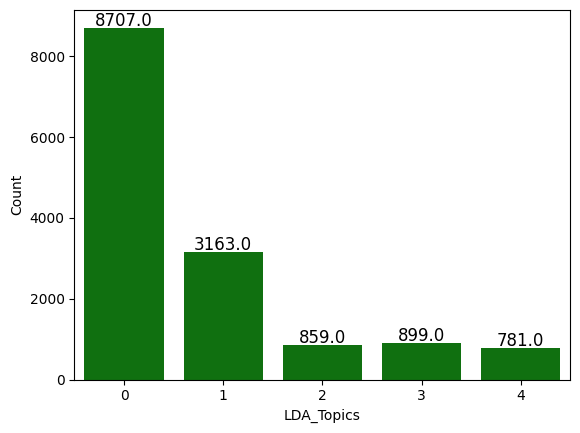

In [ ]:
# Create a count plot
ax = sns.countplot(data=dataset, x='LDA_Topics', color='green')

# Annotate the bars with their counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Set labels for the axes
plt.xlabel('LDA_Topics')
plt.ylabel('Count')


In [ ]:
 dataset.head()

,Title,Aspect,Sentiment,LDA_Topics
0,spicejet to issue 6.4 crore warrants to promoters,SpiceJet,neutral,1
1,mmtc q2 net loss at rs 10.4 crore,MMTC,neutral,1
2,"mid-cap funds can deliver more, stay put: experts",Mid-cap funds,positive,0
3,mid caps now turn into market darlings,Mid caps,positive,0
4,"market seeing patience, if not conviction: prakash diwan",Market,neutral,0


In [ ]:
df = dataset.copy()

In [ ]:
df.head()

,Title,Aspect,Sentiment,LDA_Topics
0,spicejet to issue 6.4 crore warrants to promoters,SpiceJet,neutral,1
1,mmtc q2 net loss at rs 10.4 crore,MMTC,neutral,1
2,"mid-cap funds can deliver more, stay put: experts",Mid-cap funds,positive,0
3,mid caps now turn into market darlings,Mid caps,positive,0
4,"market seeing patience, if not conviction: prakash diwan",Market,neutral,0


In [ ]:
df.shape

(14409, 4)

Topic 0: Stock Market Activity

Topic 1: Regulatory and Pharmaceutical

Topic 2: Economic Indicators

Topic 3: Financial Institutions

Topic 4: Corporate Financial Results

In [ ]:
# LDA topics
lda_topics_5 = {
    0: ["stocks", "nifty", "sensex", "ashwani", "gujral", "tata" ,"market" ,"power", "infosys", "buy"],
    1: ["sebi" ,"pharma", "financial", "deepak", "ipo" ,"stock" ,"stake", "report", "2014", "rupee"],
    2: ["shares", "high", "dollar", "stocks", "china", "week", "hits", "low", "year" ,"india"],
    3: ["stocks", "bse", "rbi", "capital" ,"nse", "oil" ,"investors", "india" ,"choksey" ,"bank"],
    4: ["rs", "crore", "net" ,"profit", "cent", "cr", "futures", "q1" ,"q2", "q3"]
}

In [ ]:
# Define your mapping dictionary
topic_to_category = {
    0: 'Market Trends and Performance',
    1: 'Corporate Actions and Market Impact',
    2: 'Market Volatility and Trade',
    3: 'Institutional Finance and Investments',
    4: 'Corporate Financial Results'
}

# Apply this mapping to your dataset
df['LDA_Aspect_Category'] = df['LDA_Topics'].map(topic_to_category)


In [ ]:
df.head(20)

,Title,Aspect,Sentiment,LDA_Topics,LDA_Aspect_Category
0,spicejet to issue 6.4 crore warrants to promoters,SpiceJet,neutral,1,Corporate Actions and Market Impact
1,mmtc q2 net loss at rs 10.4 crore,MMTC,neutral,1,Corporate Actions and Market Impact
2,"mid-cap funds can deliver more, stay put: experts",Mid-cap funds,positive,0,Market Trends and Performance
3,mid caps now turn into market darlings,Mid caps,positive,0,Market Trends and Performance
4,"market seeing patience, if not conviction: prakash diwan",Market,neutral,0,Market Trends and Performance
5,infosys: will the strong volume growth sustain?,Infosys,neutral,1,Corporate Actions and Market Impact
6,hudco raises rs 279 cr via tax-free bonds,Hudco,positive,4,Corporate Financial Results
7,hoec could retest 30-35 levels: ashwani gujral,HOEC,neutral,1,Corporate Actions and Market Impact
8,gold shines on seasonal demand; silver dull,Gold,positive,2,Market Volatility and Trade
9,gold shines on seasonal demand; silver dull,Silver,negative,2,Market Volatility and Trade


In [ ]:
# Custom model for multi-task learning
class BertForMultiTask(nn.Module):
    def __init__(self, num_aspect_labels, num_aspect_category_labels, num_sentiment_labels):
        super(BertForMultiTask, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.aspect_classifier = nn.Linear(self.bert.config.hidden_size, num_aspect_labels)
        self.aspect_category_classifier = nn.Linear(self.bert.config.hidden_size, num_aspect_category_labels)
        self.sentiment_classifier = nn.Linear(self.bert.config.hidden_size, num_sentiment_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        aspect_logits = self.aspect_classifier(pooled_output)
        aspect_category_logits = self.aspect_category_classifier(pooled_output)
        sentiment_logits = self.sentiment_classifier(pooled_output)
        return aspect_logits,aspect_category_logits, sentiment_logits


# Initialize tokenizers and label encoders
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
label_encoder_aspect = LabelEncoder()
label_encoder_aspect_category = LabelEncoder()
label_encoder_sentiment = LabelEncoder()

# Encode labels
label_encoder_aspect.fit(df['Aspect'])
label_encoder_aspect_category.fit(df['LDA_Aspect_Category'])
label_encoder_sentiment.fit(df['Sentiment'])

input_ids = []
attention_masks = []
aspect_labels = []
aspect_category_labels = []
sentiment_labels = []

for _, row in df.iterrows():
    text = row['Title']
    aspect = row['Aspect']
    aspect_category = row['LDA_Aspect_Category']
    sentiment = row['Sentiment']

    # Tokenize the text
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Append the tokenized information
    input_ids.append(encoded_dict['input_ids'][0])
    attention_masks.append(encoded_dict['attention_mask'][0])

    # Append corresponding labels
    aspect_labels.append(label_encoder_aspect.transform([aspect])[0])
    aspect_category_labels.append(label_encoder_aspect_category.transform([aspect_category])[0])
    sentiment_labels.append(label_encoder_sentiment.transform([sentiment])[0])

# Convert lists into tensors
input_ids = torch.stack(input_ids, dim=0)
attention_masks = torch.stack(attention_masks, dim=0)
aspect_labels = torch.tensor(aspect_labels)
aspect_category_labels = torch.tensor(aspect_category_labels)
sentiment_labels = torch.tensor(sentiment_labels)

# Split data
train_inputs, validation_inputs, train_aspect_labels, validation_aspect_labels, train_aspect_category_labels, validation_aspect_category_labels, train_sentiment_labels, validation_sentiment_labels = train_test_split(input_ids, aspect_labels, aspect_category_labels, sentiment_labels, random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

# DataLoader
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_aspect_labels, train_aspect_category_labels, train_sentiment_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_aspect_labels, validation_aspect_category_labels, validation_sentiment_labels )
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Initialize model
num_aspect_labels = len(label_encoder_aspect.classes_)
num_aspect_category_labels = len(label_encoder_aspect_category.classes_)
num_sentiment_labels = len(label_encoder_sentiment.classes_)
model = BertForMultiTask(num_aspect_labels,num_aspect_category_labels, num_sentiment_labels)
model.cuda()

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Training loop
epochs = 4
for epoch_i in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_aspect_labels = batch[2].cuda()
        b_aspect_category_labels = batch[3].cuda()
        b_sentiment_labels = batch[4].cuda()

        model.zero_grad()

        aspect_logits, aspect_category_logits, sentiment_logits = model(b_input_ids, attention_mask=b_input_mask)

        loss_fct = nn.CrossEntropyLoss()
        aspect_loss = loss_fct(aspect_logits, b_aspect_labels)
        aspect_category_loss = loss_fct(aspect_category_logits, b_aspect_category_labels)
        sentiment_loss = loss_fct(sentiment_logits, b_sentiment_labels)
        total_loss = aspect_loss + aspect_category_loss+ sentiment_loss

        total_train_loss += total_loss.item()
        total_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 4 ========
Average training loss: 9.61
======== Epoch 2 / 4 ========
Average training loss: 8.31
======== Epoch 3 / 4 ========
Average training loss: 7.70
======== Epoch 4 / 4 ========
Average training loss: 7.26


In [ ]:
# Evaluation Function
def evaluate(model, dataloader):
    model.eval()
    aspect_preds, aspect_category_preds, sentiment_preds = [], [], []
    true_aspect_labels,true_aspect_category_labels, true_sentiment_labels = [], [], []

    for batch in dataloader:
        batch = tuple(t.cuda() for t in batch)
        b_input_ids, b_input_mask, b_aspect_labels,b_aspect_category_labels, b_sentiment_labels = batch

        with torch.no_grad():
            aspect_logits,aspect_category_logits, sentiment_logits = model(b_input_ids, attention_mask=b_input_mask)

        aspect_logits = aspect_logits.detach().cpu().numpy()
        aspect_category_logits = aspect_category_logits.detach().cpu().numpy()
        sentiment_logits = sentiment_logits.detach().cpu().numpy()

        label_ids_aspect = b_aspect_labels.to('cpu').numpy()
        label_ids_aspect_category = b_aspect_category_labels.to('cpu').numpy()
        label_ids_sentiment = b_sentiment_labels.to('cpu').numpy()

        aspect_preds.append(aspect_logits)
        aspect_category_preds.append(aspect_category_logits)
        sentiment_preds.append(sentiment_logits)

        true_aspect_labels.append(label_ids_aspect)
        true_aspect_category_labels.append(label_ids_aspect_category)
        true_sentiment_labels.append(label_ids_sentiment)

    aspect_preds = np.concatenate(aspect_preds, axis=0)
    aspect_category_preds = np.concatenate(aspect_category_preds, axis=0)
    sentiment_preds = np.concatenate(sentiment_preds, axis=0)


    true_aspect_labels = np.concatenate(true_aspect_labels, axis=0)
    true_aspect_category_labels = np.concatenate(true_aspect_category_labels, axis=0)
    true_sentiment_labels = np.concatenate(true_sentiment_labels, axis=0)

    return aspect_preds, aspect_category_preds, sentiment_preds, true_aspect_labels,true_aspect_category_labels, true_sentiment_labels

# Evaluate the model
aspect_predictions, aspect_category_predictions, sentiment_predictions, true_aspects, true_aspects_category, true_sentiments = evaluate(model, validation_dataloader)

# Convert logits to predictions
aspect_predictions = np.argmax(aspect_predictions, axis=1)
aspect_category_predictions = np.argmax(aspect_category_predictions, axis=1)
sentiment_predictions = np.argmax(sentiment_predictions, axis=1)

# Calculate evaluation metrics for both aspect and sentiment
# Inspect unique classes in predictions and true labels
unique_true_aspects = np.unique(true_aspects)
unique_aspect_predictions = np.unique(aspect_predictions)

unique_true_aspects_category = np.unique(true_aspects_category)
unique_aspect_category_predictions = np.unique(aspect_category_predictions)


# print("Unique true aspect classes:", unique_true_aspects)
# print("Unique predicted aspect classes:", unique_aspect_predictions)


In [ ]:
# Generate classification report using 'labels' parameter
aspect_report = classification_report(true_aspects, aspect_predictions, labels=unique_true_aspects)
aspect_category_report = classification_report(true_aspects_category, aspect_category_predictions, labels=unique_true_aspects_category)
sentiment_report = classification_report(true_sentiments, sentiment_predictions, labels=np.unique(true_sentiments))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Aspect Classification Report:\n", aspect_report)

Aspect Classification Report:
               precision    recall  f1-score   support

           5       0.00      0.00      0.00         2
          20       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         1
          45       0.00      0.00      0.00         1
          48       0.00      0.00      0.00         2
          67       0.00      0.00      0.00         1
          71       0.00      0.00      0.00         1
          78       0.00      0.00      0.00         1
          87       0.00      0.00      0.00         2
          88       0.00      0.00      0.00         1
          90       0.00      0.00      0.00         1
          91       0.00      0.00      0.00         1
         100       0.00      0.00      0.00         1
         105       0.00      0.00      0.00         1
         106       0.00      0.00      0.00         1
         115       0.00      0.00      0.00       

In [ ]:
print("Aspect Category Classification Report:\n", aspect_category_report)

Aspect Category Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.74      0.70       296
           1       0.58      0.61      0.59        77
           2       0.57      0.38      0.46        86
           3       0.86      0.85      0.85       884
           4       0.73      0.77      0.75        98

    accuracy                           0.78      1441
   macro avg       0.68      0.67      0.67      1441
weighted avg       0.78      0.78      0.78      1441



In [ ]:
print("Sentiment Classification Report:\n", sentiment_report)

Sentiment Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       373
           1       0.78      0.76      0.77       577
           2       0.81      0.81      0.81       491

    accuracy                           0.80      1441
   macro avg       0.80      0.80      0.80      1441
weighted avg       0.80      0.80      0.80      1441



In [ ]:
def prepare_input(text):
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=64,           # Pad & truncate all sentences.
        truncation=True,
        padding='max_length',
        return_attention_mask=True,   # Construct attention masks.
        return_tensors='pt',     # Return pytorch tensors.
    )

    return encoded_dict['input_ids'], encoded_dict['attention_mask']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure the model is on the correct device

BertForMultiTask(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
def predict(model, text):
    model.eval()  # Put the model in evaluation mode

    input_ids, attention_mask = prepare_input(text)

    with torch.no_grad():
        # Move input tensors to the correct device
        aspect_logits, aspect_category_logits, sentiment_logits = model(input_ids.to(device), attention_mask=attention_mask.to(device))


    # Convert logits to probabilities
    aspect_probs = torch.nn.functional.softmax(aspect_logits, dim=-1)
    aspect_category_probs = torch.nn.functional.softmax(aspect_category_logits, dim=-1)
    sentiment_probs = torch.nn.functional.softmax(sentiment_logits, dim=-1)

    # Get the highest probability index
    aspect_prediction = torch.argmax(aspect_probs, dim=-1)
    aspect_category_prediction = torch.argmax(aspect_category_probs, dim=-1)
    sentiment_prediction = torch.argmax(sentiment_probs, dim=-1)

    return aspect_prediction,aspect_category_prediction, sentiment_prediction


In [ ]:
def decode_predictions(aspect_pred,aspect_category_pred, sentiment_pred):
    # Convert predictions to 1D array if they are not
    aspect_pred = aspect_pred.cpu().numpy().ravel()  # Flatten to 1D array
    aspect_category_pred = aspect_category_pred.cpu().numpy().ravel()  # Flatten to 1D array
    sentiment_pred = sentiment_pred.cpu().numpy().ravel()  # Flatten to 1D array

    aspect_label = label_encoder_aspect.inverse_transform([aspect_pred])[0]
    aspect_category_label = label_encoder_aspect_category.inverse_transform([aspect_category_pred])[0]
    sentiment_label = label_encoder_sentiment.inverse_transform([sentiment_pred])[0]
    return aspect_label, aspect_category_label, sentiment_label


In [ ]:
# Example text
text = "Gold prices are going up!"

# Predict
aspect_pred,aspect_category_pred, sentiment_pred = predict(model, text)

# Decode predictions
aspect_label, aspect_category_label, sentiment_label = decode_predictions(aspect_pred, aspect_category_pred, sentiment_pred)

print(f"Predicted Aspect: {aspect_label} \nPredicted Aspect Category: {aspect_category_label} \nPredicted Sentiment: {sentiment_label}")


Predicted Aspect: Gold 
Predicted Aspect Category: Market Volatility and Trade 
Predicted Sentiment: positive


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
df.head(10)

,Title,Aspect,Sentiment,LDA_Topics,LDA_Aspect_Category
0,spicejet to issue 6.4 crore warrants to promoters,SpiceJet,neutral,1,Corporate Actions and Market Impact
1,mmtc q2 net loss at rs 10.4 crore,MMTC,neutral,1,Corporate Actions and Market Impact
2,"mid-cap funds can deliver more, stay put: experts",Mid-cap funds,positive,0,Market Trends and Performance
3,mid caps now turn into market darlings,Mid caps,positive,0,Market Trends and Performance
4,"market seeing patience, if not conviction: prakash diwan",Market,neutral,0,Market Trends and Performance
5,infosys: will the strong volume growth sustain?,Infosys,neutral,1,Corporate Actions and Market Impact
6,hudco raises rs 279 cr via tax-free bonds,Hudco,positive,4,Corporate Financial Results
7,hoec could retest 30-35 levels: ashwani gujral,HOEC,neutral,1,Corporate Actions and Market Impact
8,gold shines on seasonal demand; silver dull,Gold,positive,2,Market Volatility and Trade
9,gold shines on seasonal demand; silver dull,Silver,negative,2,Market Volatility and Trade


In [ ]:
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import random
import pandas as pd

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# def get_synonyms(word):
#     synonyms = set()
#     for syn in wordnet.synsets(word):
#         for lemma in syn.lemmas():
#             synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
#             synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
#             synonyms.add(synonym)
#     if word in synonyms:
#         synonyms.remove(word)
#     return list(synonyms)

# def synonym_replacement(sentence, n=2):
#     words = sentence.split()
#     new_words = words.copy()
#     random_word_list = list(set([word for word in words if word not in stopwords.words('english')]))
#     random.shuffle(random_word_list)
#     num_replaced = 0
#     for random_word in random_word_list:
#         synonyms = get_synonyms(random_word)
#         if len(synonyms) >= 1:
#             synonym = random.choice(list(synonyms))
#             new_words = [synonym if word == random_word else word for word in new_words]
#             num_replaced += 1
#         if num_replaced >= n:
#             break

#     sentence = ' '.join(new_words)
#     return sentence


In [ ]:
df['LDA_Aspect_Category'].value_counts()

Market Trends and Performance            8707
Corporate Actions and Market Impact      3163
Institutional Finance and Investments    899 
Market Volatility and Trade              859 
Corporate Financial Results              781 
Name: LDA_Aspect_Category, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import random
from nltk.corpus import wordnet, stopwords
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:


# # Assuming df is your DataFrame and it's already loaded

# def get_synonyms(word):
#     synonyms = set()
#     for syn in wordnet.synsets(word):
#         for lemma in syn.lemmas():
#             synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
#             synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
#             synonyms.add(synonym)
#     if word in synonyms:
#         synonyms.remove(word)
#     return list(synonyms)

# def synonym_replacement(sentence, n=2):
#     words = sentence.split()
#     new_words = words.copy()
#     random_word_list = list(set([word for word in words if word not in stopwords.words('english')]))
#     random.shuffle(random_word_list)
#     num_replaced = 0
#     for random_word in random_word_list:
#         synonyms = get_synonyms(random_word)
#         if len(synonyms) >= 1:
#             synonym = random.choice(list(synonyms))
#             new_words = [synonym if word == random_word else word for word in new_words]
#             num_replaced += 1
#         if num_replaced >= n:
#             break

#     sentence = ' '.join(new_words)
#     return sentence

# # Specify categories to augment
# categories_to_augment = ['Corporate Financial Results', 'Economic Indicators', 'Financial Institutions','Regulatory and Pharmaceutical']

# # Initialize an empty DataFrame for augmented data
# augmented_data = pd.DataFrame(columns=df.columns)

# # Define the number of times you want to augment each title
# augmentation_factor = 6  # or more, based on how balanced you want the categories to be

# for category in categories_to_augment:
#     # Filter the dataset for the specific category
#     underrepresented_df = df[df['LDA_Aspect_Category'] == category]

#     # Augment each title in the underrepresented category
#     for _ in range(augmentation_factor):
#         augmented_titles = underrepresented_df['Title'].apply(lambda x: synonym_replacement(x))
#         augmented_df = underrepresented_df.copy()
#         augmented_df['Title'] = augmented_titles
#         augmented_data = pd.concat([augmented_data, augmented_df])

# # Combine the original and augmented data
# df_balanced = pd.concat([df, augmented_data])

# # Optionally, you might want to drop duplicates if any
# df_balanced.drop_duplicates(subset=['Title'], inplace=True)

# # Shuffle the DataFrame if necessary
# df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

# print(df_balanced['LDA_Aspect_Category'].value_counts())


In [ ]:
# df_balanced.head(20)

In [ ]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

In [ ]:
def synonym_replacement(sentence, n=2):
    if not sentence:  # Check if the sentence is None or empty
        return sentence  # Return the original sentence
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stopwords.words('english')]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    # Ensure the sentence is not empty or None
    new_sentence = ' '.join(new_words)
    return new_sentence if new_sentence else sentence


In [ ]:
df.head()

,Title,Aspect,Sentiment,LDA_Topics,LDA_Aspect_Category
0,spicejet to issue 6.4 crore warrants to promoters,SpiceJet,neutral,1,Corporate Actions and Market Impact
1,mmtc q2 net loss at rs 10.4 crore,MMTC,neutral,1,Corporate Actions and Market Impact
2,"mid-cap funds can deliver more, stay put: experts",Mid-cap funds,positive,0,Market Trends and Performance
3,mid caps now turn into market darlings,Mid caps,positive,0,Market Trends and Performance
4,"market seeing patience, if not conviction: prakash diwan",Market,neutral,0,Market Trends and Performance


In [ ]:
df.isnull().sum()

Title                  0
Aspect                 0
Sentiment              0
LDA_Topics             0
LDA_Aspect_Category    0
dtype: int64

In [ ]:
df['LDA_Aspect_Category'].value_counts()

Market Trends and Performance            8707
Corporate Actions and Market Impact      3163
Institutional Finance and Investments    899 
Market Volatility and Trade              859 
Corporate Financial Results              781 
Name: LDA_Aspect_Category, dtype: int64

In [ ]:
# Assuming 'df' is your DataFrame

# Define target counts for each category based on your desired distribution
target_counts = {
    "Market Trends and Performance": 8707,  # This is the highest, so it might not need augmentation
    "Corporate Actions and Market Impact": 3163 * 2,  # This might not need augmentation
    "Institutional Finance and Investments": 899 * 8,  # Example target after augmentation
    "Market Volatility and Trade": 859 * 9,  # Example target after augmentation
    "Corporate Financial Results": 781 * 9  # Example target after augmentation
}

# Initialize an empty DataFrame for augmented data
augmented_data = pd.DataFrame(columns=df.columns)


# Perform selective augmentation
for category, target_count in target_counts.items():
    category_df = df[df['LDA_Aspect_Category'] == category]
    current_count = len(category_df)

    # Calculate how many more samples are needed to reach the target count
    samples_needed = target_count - current_count

    # If augmentation is needed
    if samples_needed > 0:
        # Calculate the number of times each row needs to be augmented
        augmentation_factor = int(np.ceil(samples_needed / current_count))

        # Apply augmentation
        for i in range(augmentation_factor):
            augmented_category_df = category_df.copy()
            augmented_category_df['Title'] = augmented_category_df['Title'].apply(lambda x: synonym_replacement(x, n=2))
            augmented_data = pd.concat([augmented_data, augmented_category_df])

# Combine the original data with the augmented data
df_augmented = pd.concat([df, augmented_data])

# Shuffle the DataFrame if necessary
df_augmented = df_augmented.sample(frac=1).reset_index(drop=True)

# Check the new value counts to verify balance
print(df_augmented['LDA_Aspect_Category'].value_counts())


Market Trends and Performance            8707
Institutional Finance and Investments    7192
Corporate Financial Results              7029
Corporate Actions and Market Impact      6326
Market Volatility and Trade              859 
Name: LDA_Aspect_Category, dtype: int64


In [ ]:
df_augmented.head(20)

,Title,Aspect,Sentiment,LDA_Topics,LDA_Aspect_Category
0,"market bets on tcs, but infosys seen dark horse of it pack",Infosys,positive,1,Corporate Actions and Market Impact
1,ceat shares up over 4% after workers call off strike,Ceat shares,positive,0,Market Trends and Performance
2,jainist irrigation in talks with international finance corporation for stake sale: sources,IFC,neutral,3,Institutional Finance and Investments
3,fixed-income fund under sebi examination after huge outflows,Sebi,neutral,1,Corporate Actions and Market Impact
4,"long term gains in metals look on us taper, taiwanese reforms: ur bhat",metals,neutral,3,Institutional Finance and Investments
5,"would stick around to banking: girish pai, centrum broking",banking,positive,3,Institutional Finance and Investments
6,"electrolux q1 profit top of the inning forecast, bandstand by market outlook",Electrolux,positive,4,Corporate Financial Results
7,"firm demand, tight arrivals lift cardamom futures by 0.85%",cardamom,positive,3,Institutional Finance and Investments
8,multiple triggers drive up ril 10% in iii hour interval,RIL,positive,1,Corporate Actions and Market Impact
9,fear of post-poll price drop quarter people to betray gold,gold,negative,3,Institutional Finance and Investments


In [ ]:
df_augmented.to_csv('df_finance_absa_lda_aug.csv', index=False)


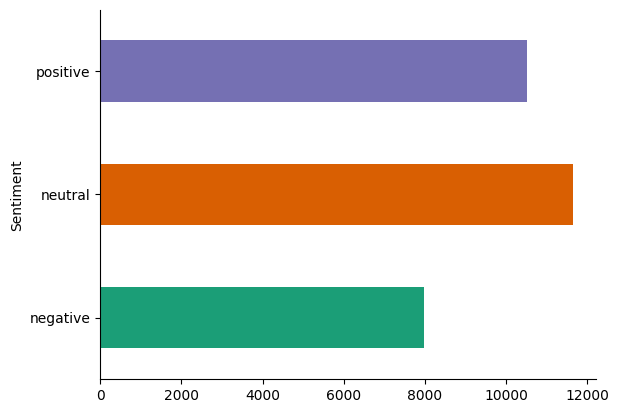

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_augmented.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

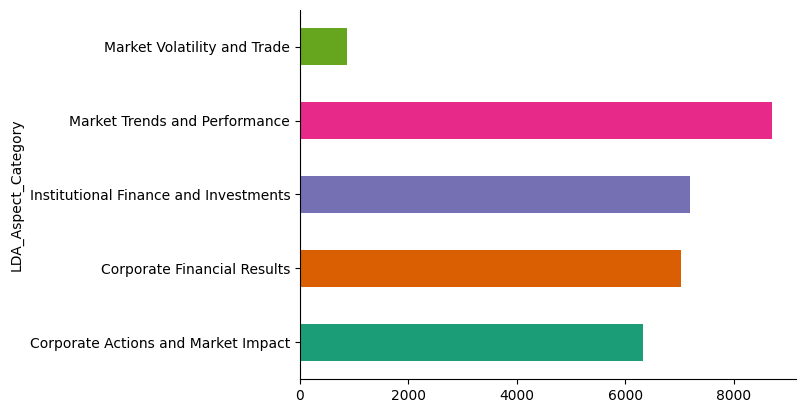

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_augmented.groupby('LDA_Aspect_Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Custom model for multi-task learning
class BertForMultiTask(nn.Module):
    def __init__(self, num_aspect_labels, num_aspect_category_labels, num_sentiment_labels):
        super(BertForMultiTask, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.aspect_classifier = nn.Linear(self.bert.config.hidden_size, num_aspect_labels)
        self.aspect_category_classifier = nn.Linear(self.bert.config.hidden_size, num_aspect_category_labels)
        self.sentiment_classifier = nn.Linear(self.bert.config.hidden_size, num_sentiment_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        aspect_logits = self.aspect_classifier(pooled_output)
        aspect_category_logits = self.aspect_category_classifier(pooled_output)
        sentiment_logits = self.sentiment_classifier(pooled_output)
        return aspect_logits,aspect_category_logits, sentiment_logits


# Initialize tokenizers and label encoders
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
label_encoder_aspect = LabelEncoder()
label_encoder_aspect_category = LabelEncoder()
label_encoder_sentiment = LabelEncoder()

# Encode labels
label_encoder_aspect.fit(df_augmented['Aspect'])
label_encoder_aspect_category.fit(df_augmented['LDA_Aspect_Category'])
label_encoder_sentiment.fit(df_augmented['Sentiment'])

input_ids = []
attention_masks = []
aspect_labels = []
aspect_category_labels = []
sentiment_labels = []

for _, row in df_augmented.iterrows():
    text = row['Title']
    aspect = row['Aspect']
    aspect_category = row['LDA_Aspect_Category']
    sentiment = row['Sentiment']

    # Tokenize the text
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Append the tokenized information
    input_ids.append(encoded_dict['input_ids'][0])
    attention_masks.append(encoded_dict['attention_mask'][0])

    # Append corresponding labels
    aspect_labels.append(label_encoder_aspect.transform([aspect])[0])
    aspect_category_labels.append(label_encoder_aspect_category.transform([aspect_category])[0])
    sentiment_labels.append(label_encoder_sentiment.transform([sentiment])[0])

# Convert lists into tensors
input_ids = torch.stack(input_ids, dim=0)
attention_masks = torch.stack(attention_masks, dim=0)
aspect_labels = torch.tensor(aspect_labels)
aspect_category_labels = torch.tensor(aspect_category_labels)
sentiment_labels = torch.tensor(sentiment_labels)

# Split data
train_inputs, validation_inputs, train_aspect_labels, validation_aspect_labels, train_aspect_category_labels, validation_aspect_category_labels, train_sentiment_labels, validation_sentiment_labels = train_test_split(input_ids, aspect_labels, aspect_category_labels, sentiment_labels, random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

# DataLoader
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_aspect_labels, train_aspect_category_labels, train_sentiment_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_aspect_labels, validation_aspect_category_labels, validation_sentiment_labels )
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Initialize model
num_aspect_labels = len(label_encoder_aspect.classes_)
num_aspect_category_labels = len(label_encoder_aspect_category.classes_)
num_sentiment_labels = len(label_encoder_sentiment.classes_)
model = BertForMultiTask(num_aspect_labels,num_aspect_category_labels, num_sentiment_labels)
model.cuda()

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Training loop
epochs = 6
for epoch_i in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_aspect_labels = batch[2].cuda()
        b_aspect_category_labels = batch[3].cuda()
        b_sentiment_labels = batch[4].cuda()

        model.zero_grad()

        aspect_logits, aspect_category_logits, sentiment_logits = model(b_input_ids, attention_mask=b_input_mask)

        loss_fct = nn.CrossEntropyLoss()
        aspect_loss = loss_fct(aspect_logits, b_aspect_labels)
        aspect_category_loss = loss_fct(aspect_category_logits, b_aspect_category_labels)
        sentiment_loss = loss_fct(sentiment_logits, b_sentiment_labels)
        total_loss = aspect_loss + aspect_category_loss+ sentiment_loss

        total_train_loss += total_loss.item()
        total_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 6 ========
Average training loss: 8.64
======== Epoch 2 / 6 ========
Average training loss: 6.70
======== Epoch 3 / 6 ========
Average training loss: 5.78
======== Epoch 4 / 6 ========
Average training loss: 5.13
======== Epoch 5 / 6 ========
Average training loss: 4.62
======== Epoch 6 / 6 ========
Average training loss: 4.18


In [ ]:
# Evaluation Function
def evaluate(model, dataloader):
    model.eval()
    aspect_preds, aspect_category_preds, sentiment_preds = [], [], []
    true_aspect_labels,true_aspect_category_labels, true_sentiment_labels = [], [], []

    for batch in dataloader:
        batch = tuple(t.cuda() for t in batch)
        b_input_ids, b_input_mask, b_aspect_labels,b_aspect_category_labels, b_sentiment_labels = batch

        with torch.no_grad():
            aspect_logits,aspect_category_logits, sentiment_logits = model(b_input_ids, attention_mask=b_input_mask)

        aspect_logits = aspect_logits.detach().cpu().numpy()
        aspect_category_logits = aspect_category_logits.detach().cpu().numpy()
        sentiment_logits = sentiment_logits.detach().cpu().numpy()

        label_ids_aspect = b_aspect_labels.to('cpu').numpy()
        label_ids_aspect_category = b_aspect_category_labels.to('cpu').numpy()
        label_ids_sentiment = b_sentiment_labels.to('cpu').numpy()

        aspect_preds.append(aspect_logits)
        aspect_category_preds.append(aspect_category_logits)
        sentiment_preds.append(sentiment_logits)

        true_aspect_labels.append(label_ids_aspect)
        true_aspect_category_labels.append(label_ids_aspect_category)
        true_sentiment_labels.append(label_ids_sentiment)

    aspect_preds = np.concatenate(aspect_preds, axis=0)
    aspect_category_preds = np.concatenate(aspect_category_preds, axis=0)
    sentiment_preds = np.concatenate(sentiment_preds, axis=0)


    true_aspect_labels = np.concatenate(true_aspect_labels, axis=0)
    true_aspect_category_labels = np.concatenate(true_aspect_category_labels, axis=0)
    true_sentiment_labels = np.concatenate(true_sentiment_labels, axis=0)

    return aspect_preds, aspect_category_preds, sentiment_preds, true_aspect_labels,true_aspect_category_labels, true_sentiment_labels

# Evaluate the model
aspect_predictions, aspect_category_predictions, sentiment_predictions, true_aspects, true_aspects_category, true_sentiments = evaluate(model, validation_dataloader)

# Convert logits to predictions
aspect_predictions = np.argmax(aspect_predictions, axis=1)
aspect_category_predictions = np.argmax(aspect_category_predictions, axis=1)
sentiment_predictions = np.argmax(sentiment_predictions, axis=1)

# Calculate evaluation metrics for both aspect and sentiment
# Inspect unique classes in predictions and true labels
unique_true_aspects = np.unique(true_aspects)
unique_aspect_predictions = np.unique(aspect_predictions)

unique_true_aspects_category = np.unique(true_aspects_category)
unique_aspect_category_predictions = np.unique(aspect_category_predictions)


# print("Unique true aspect classes:", unique_true_aspects)
# print("Unique predicted aspect classes:", unique_aspect_predictions)


In [ ]:
# Generate classification report using 'labels' parameter
aspect_report = classification_report(true_aspects, aspect_predictions, labels=unique_true_aspects)
aspect_category_report = classification_report(true_aspects_category, aspect_category_predictions, labels=unique_true_aspects_category)
sentiment_report = classification_report(true_sentiments, sentiment_predictions, labels=np.unique(true_sentiments))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Aspect Classification Report:\n", aspect_report)

Aspect Classification Report:
               precision    recall  f1-score   support

           7       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         4
          41       0.00      0.00      0.00         1
          45       0.00      0.00      0.00         1
          47       0.25      1.00      0.40         4
          48       0.00      0.00      0.00         2
          51       0.00      0.00      0.00         1
          52       0.00      0.00      0.00         1
          65       0.00      0.00      0.00         1
          75       0.00      0.00      0.00         1
          78       0.00      0.00      0.00         1
          81       0.00      0.00      0.00         1
          94       0.00      0.00      0.00         1
         103       0.00      0.00      0.00         1
         109       0.00      0.00      0.00       

In [ ]:
print("Aspect Category Classification Report:\n", aspect_category_report)

Aspect Category Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79       670
           1       0.92      0.93      0.93       721
           2       0.89      0.90      0.89       707
           3       0.80      0.83      0.81       829
           4       0.72      0.74      0.73        85

    accuracy                           0.85      3012
   macro avg       0.83      0.83      0.83      3012
weighted avg       0.85      0.85      0.85      3012



In [ ]:
print("Sentiment Classification Report:\n", sentiment_report)

Sentiment Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87       783
           1       0.86      0.87      0.86      1135
           2       0.90      0.88      0.89      1094

    accuracy                           0.88      3012
   macro avg       0.88      0.87      0.88      3012
weighted avg       0.88      0.88      0.88      3012

